In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.metrics import accuracy_score, f1_score
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['figure.figsize'] = (11.0, 8.0)

TT_SPLIT = 0.30
RAND_STATE = 42

In [2]:
os.chdir('../modded')
df = pd.read_csv('data/eth_txn_unscaled_Vars_SQLformatted.csv')
df.head()

,address,avg_min_between_sent_txn,avg_min_between_received_txn,time_diff_between_first_and_last_mins,unique_received_from_addresses,min_val_received,max_val_received,min_val_sent,avg_val_sent,total_transactions_inc_cnts,total_ether_received,total_ether_balance,flag
0,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,844.26,1093.71,704785.63,40,0.000000,45.806785,0.00,1.200681,810,586.466675,-279.224419,0
1,0x0002b44ddb1476db43c868bd494422ee4c136fed,12709.07,2958.44,1218216.73,5,0.000000,2.613269,0.00,0.032844,102,3.085478,-0.001819,0
2,0x0002bda54cb772d040f779e88eb453cac0daa244,246194.54,2434.02,516729.30,10,0.113119,1.165453,0.05,1.794308,12,3.589057,0.000441,0
3,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,10219.60,15785.09,397555.90,7,0.000000,500.000000,0.00,70.001834,34,895.399559,-854.646303,0
4,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,36.61,10707.77,382472.42,7,0.000000,12.802411,0.00,0.022688,4619,53.421897,-50.896986,0


X,y and Test/Train split

In [3]:
X = df.drop(columns=['address', 'flag'])
y = df['flag']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=TT_SPLIT,
                                                    random_state=RAND_STATE,
                                                    stratify=y)

In [4]:
X.describe()

,avg_min_between_sent_txn,avg_min_between_received_txn,time_diff_between_first_and_last_mins,unique_received_from_addresses,min_val_received,max_val_received,min_val_sent,avg_val_sent,total_transactions_inc_cnts,total_ether_received,total_ether_balance
count,8956.000000,8956.000000,8.956000e+03,8956.000000,8956.000000,8956.000000,8956.000000,8956.000000,8956.000000,8.956000e+03,8.956000e+03
mean,5377.734193,8257.116958,2.341664e+05,31.323135,47.434221,572.762378,5.050094,48.402735,299.734703,1.276619e+04,1.617608e+03
std,22150.285878,23409.226655,3.308292e+05,302.164717,337.230957,13635.334342,145.275464,249.179387,1382.674241,3.817581e+05,2.541209e+05
min,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,-1.560535e+07
25%,0.000000,0.000000,3.211700e+02,1.000000,0.003000,1.018137,0.000000,0.148596,4.000000,4.743209e+00,9.100000e-04
50%,21.510000,753.375000,6.911901e+04,2.000000,0.100000,8.371735,0.056169,1.991071,10.000000,4.142685e+01,1.988715e-03
75%,735.320000,5868.422500,3.224263e+05,5.000000,3.131381,78.433615,0.998974,27.885407,66.000000,1.010000e+02,6.692350e-02
max,430287.670000,482175.490000,1.954861e+06,9999.000000,10000.000000,800000.000000,12000.000000,12000.000000,19995.000000,2.858159e+07,1.428864e+07


Transforming the features

In [5]:
# log on both train and test data
scaler = MinMaxScaler()
wash_log = False

if wash_log:
    for c in X_train.columns:
        X_train[c] = X_train[c].apply(lambda x: np.log(x) if x > 0 else 0)
        X_test[c] = X_test[c].apply(lambda x: np.log(x) if x > 0 else 0)

    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

else:
    pt = PowerTransformer().fit(X_train)
    # set up the transformer to power transform all float64 columns and scale all columns
    scaler.fit(X_train)

    X_train = pd.DataFrame(pt.transform(X_train), columns=X_train.columns)
    X_test = pd.DataFrame(pt.transform(X_test), columns=X_test.columns)


In [23]:
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [6]:
# get all the columns in X_train having skew more than 10
skew_features = X_train[X_train.select_dtypes(include=['float64']).columns].skew(axis = 0, skipna = True)
skew_features

avg_min_between_sent_txn                 0.184574
avg_min_between_received_txn            -0.070381
time_diff_between_first_and_last_mins   -0.272236
unique_received_from_addresses           0.076155
min_val_received                         0.861555
max_val_received                         0.141929
min_val_sent                             0.796327
avg_val_sent                             0.281685
total_transactions_inc_cnts              0.130139
total_ether_received                     0.024192
total_ether_balance                     -4.134557
dtype: float64

In [7]:
skew_features_idx = skew_features[np.abs(skew_features) > .5].index

In [8]:
skew_features_idx

Index(['min_val_received', 'min_val_sent', 'total_ether_balance'], dtype='object')

In [9]:
X_train[skew_features_idx] = pt.fit_transform(X_train[skew_features_idx])
X_test[skew_features_idx] = pt.transform(X_test[skew_features_idx])

In [12]:
skew_features = X_train[X_train.select_dtypes(include=['float64']).columns].skew(axis = 0, skipna = True)
skew_features

avg_min_between_sent_txn                 0.184574
avg_min_between_received_txn            -0.070381
time_diff_between_first_and_last_mins   -0.272236
unique_received_from_addresses           0.076155
min_val_received                         0.466202
max_val_received                         0.141929
min_val_sent                             0.416169
avg_val_sent                             0.281685
total_transactions_inc_cnts              0.130139
total_ether_received                     0.024192
total_ether_balance                     -1.286904
dtype: float64

In [13]:
###Creating Naive Bayes Classifier Model
GNB = GaussianNB(var_smoothing=2e-9)
GNB.fit(X_train,y_train)
y_pr = GNB.predict(X_test)
print('Accuracy Score: ', accuracy_score(y_test, y_pr))
print('F1 Score: ', f1_score(y_test, y_pr))

Accuracy Score:  0.502046892445106
F1 Score:  0.3694627709707823


In [14]:
### Doing Grid Search to find best hyperparameters
from sklearn.model_selection import GridSearchCV

param_grid_nb = {
    'var_smoothing': np.logspace(0, -9, num=100),
}

grid_search_nb = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid_nb, verbose=2, cv=5, scoring='f1')

In [15]:
import time
start_time = time.time()
grid_search_nb.fit(X_train,y_train)
print(time.time() - start_time)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ..................................var_smoothing=1.0; total time=   0.0s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ...................var_smoothing=0.8111308307896871; total time=   0.0s
[CV] END ....................var_smoothing=0.657933224657568; total time=   0.0s
[CV] END ....................var_smoothing=0.6

In [16]:
print("Tuned Hyperparameters :", grid_search_nb.best_params_)
print("Train F1 Score :",grid_search_nb.best_score_)
best_y_pr = grid_search_nb.predict(X_test)
print('Test F1 Score: ', f1_score(y_test, best_y_pr))

Tuned Hyperparameters : {'var_smoothing': 0.1}
Train F1 Score : 0.5231824236741449
Test F1 Score:  0.5277777777777778


In [17]:
from sklearn.metrics import f1_score, roc_auc_score, recall_score, accuracy_score, precision_score
logreg = GaussianNB(var_smoothing=0.0533669923120631)
logreg.fit(X_train,y_train)
y_pred = logreg.predict(X_test)
print(f1_score(y_test,y_pred))
print(roc_auc_score(y_test,y_pred))
print(recall_score(y_test,y_pred))
print(accuracy_score(y_test,y_pred))
print(precision_score(y_test,y_pred))

0.5163868904876099
0.7841729693467935
0.7975308641975308
0.7748418310383327
0.3817966903073286


In [14]:
# from sklearn.inspection import permutation_importance
# imps = permutation_importance(grid_search_nb, X_test, y_test)
# # imps['importances']
# imps

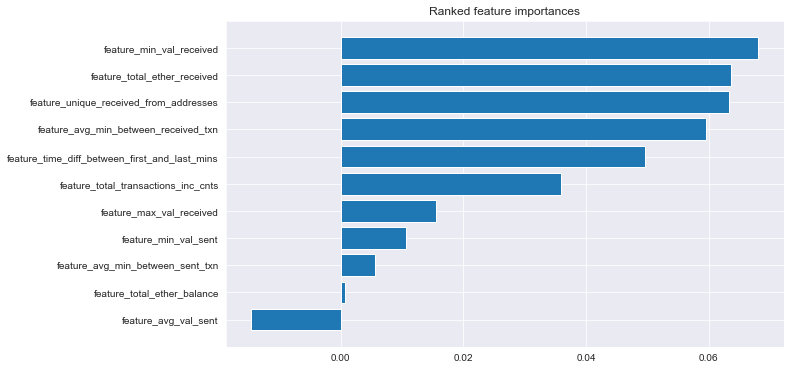

In [18]:
from sklearn.inspection import permutation_importance
feat_importances = permutation_importance(grid_search_nb, X_test, y_test)['importances_mean']
indices = np.argsort(feat_importances)
# plot
fig, ax = plt.subplots(figsize=(10, 6))
plt.title("Ranked feature importances")
plt.barh(range(len(feat_importances)), feat_importances[indices], align="center")
features = ['feature_{}'.format(X_train.columns[i]) for i in range(len(X_train.columns))]
plt.yticks(range(len(feat_importances)), [features[idx] for idx in indices])
plt.ylim([-1, len(feat_importances)])
plt.show();

In [19]:
best_y_pr = grid_search_nb.predict(X_test)
print('Accuracy Score: ', accuracy_score(y_test, best_y_pr))
print('Test F1 Score: ', f1_score(y_test, best_y_pr))

Accuracy Score:  0.7975437290658727
Test F1 Score:  0.5277777777777778


In [21]:
best_nb = GaussianNB(var_smoothing=0.0533669923120631)
best_nb.fit(X_train,y_train)

GaussianNB(var_smoothing=0.0533669923120631)

In [22]:
best_nb.theta_

array([[ 4.50431381e-02,  4.49122307e-02,  5.79000687e-02,
        -1.09286775e-02,  9.08730874e-02,  1.19680654e-01,
        -1.31309000e-02,  6.26340038e-02,  9.01248544e-02,
         1.37755910e-01, -1.83734193e-04],
       [-2.53766844e-01, -2.53029329e-01, -3.26201022e-01,
         6.15706656e-02, -5.11966473e-01, -6.74264341e-01,
         7.39776840e-02, -3.52871361e-01, -5.07751031e-01,
        -7.76097847e-01,  1.03513317e-03]])

In [23]:
best_nb.var_

array([[0.99016285, 1.11496023, 1.0829064 , 0.79781597, 1.10612574,
        1.03552904, 1.02782895, 1.0893204 , 0.96448453, 0.98226678,
        1.23086192],
       [1.33362238, 0.63097121, 0.76165187, 2.48864248, 0.44749783,
        0.61853474, 1.1908007 , 0.70419047, 1.25054646, 0.7446959 ,
        0.05338371]])

In [24]:
best_nb.classes_

array([0, 1])

In [28]:
feature_dict = {'feature_name': [], 'mean': [], 'variance': [], 'fraud': []}

for label in range(len(best_nb.theta_)):
     for mean, var, col_name in zip(best_nb.theta_[label], best_nb.var_[label], X_train.columns):
        feature_dict['feature_name'].append(col_name)
        feature_dict['mean'].append(mean)
        feature_dict['variance'].append(var)
        feature_dict['fraud'].append(label)
df2 = pd.DataFrame(feature_dict)

In [29]:
df2

,feature_name,mean,variance,fraud
0,avg_min_between_sent_txn,0.045043,0.990163,0
1,avg_min_between_received_txn,0.044912,1.114960,0
2,time_diff_between_first_and_last_mins,0.057900,1.082906,0
3,unique_received_from_addresses,-0.010929,0.797816,0
4,min_val_received,0.090873,1.106126,0
5,max_val_received,0.119681,1.035529,0
6,min_val_sent,-0.013131,1.027829,0
7,avg_val_sent,0.062634,1.089320,0
8,total_transactions_inc_cnts,0.090125,0.964485,0
9,total_ether_received,0.137756,0.982267,0
